In [1]:
import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel(r'energy_data.xlsx')

In [3]:
df

,Unnamed: 0,Datetime,Energy delta
0,1,2019-10-29 01:00:00,0.000
1,2,2019-10-29 02:00:00,0.000
2,3,2019-10-29 03:00:00,0.000
3,4,2019-10-29 04:00:00,0.000
4,5,2019-10-29 05:00:00,0.000
...,...,...,...
4219,4220,2020-04-21 20:00:00,0.004
4220,4221,2020-04-21 21:00:00,0.000
4221,4222,2020-04-21 22:00:00,0.000
4222,4223,2020-04-21 23:00:00,0.000


In [4]:
df_data = df.iloc[:,2].values
df_data = df_data.reshape(-1)

In [5]:
df_data

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

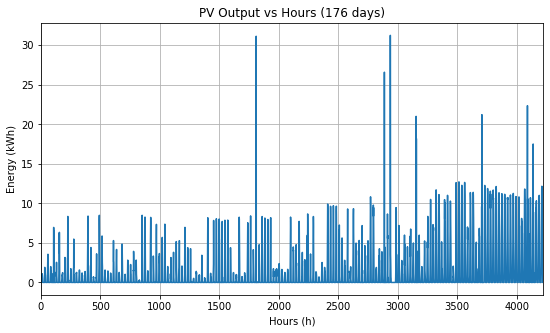

In [7]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('PV Output vs Hours (176 days)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Hours (h)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_data)

In [8]:
test_data_size = 24

train_data = df_data[:-test_data_size]
test_data = df_data[-test_data_size:]

In [9]:
print(len(train_data))
print(len(test_data))

4200
24


In [10]:
print(test_data)

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 9.0600e-01 2.4240e+00 5.0860e+00 6.9860e+00 1.0198e+01 1.1817e+01
 1.2165e+01 1.1649e+01 1.0629e+01 9.0530e+00 6.1790e+00 2.4610e+00
 3.6600e-01 4.0000e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [12]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.999936]
 [-1.      ]
 [-1.      ]
 [-1.      ]
 [-1.      ]]


In [13]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized

tensor([-1., -1., -1.,  ..., -1., -1., -1.])

In [14]:
train_window = 24

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [17]:
len(train_inout_seq)

4176

In [18]:
train_inout_seq[:1]

[(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9871,
          -0.9585, -0.9588, -0.9296, -0.9343, -0.9409, -0.9542, -0.9638, -0.9939,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]),
  tensor([-1.]))]

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [22]:
epochs = 11
print(time.ctime())
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
print(time.ctime())

Wed Apr 29 20:44:35 2020
epoch:   0 loss: 0.01585136
epoch:   1 loss: 0.00124176
epoch:   2 loss: 0.00034515
epoch:   3 loss: 0.00061869
epoch:   4 loss: 0.00056689
epoch:   5 loss: 0.00044543
epoch:   6 loss: 0.00034562
epoch:   7 loss: 0.00027765
epoch:   8 loss: 0.00023384
epoch:   9 loss: 0.00020804
epoch:  10 loss: 0.00019547
epoch:  10 loss: 0.0001954696
Wed Apr 29 20:55:17 2020


# #Example

In [ ]:
model.state_dict()

In [ ]:
torch.save(model.state_dict(), '20_epochs_energy.pt')

model = LSTM()
model.load_state_dict(torch.load('10_epochs_energy.pt'))

In [ ]:
fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

In [ ]:
fut_pred = 24

In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [ ]:
test_inputs[fut_pred:]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[fut_pred:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
x = np.arange(4200, 4224, 1)
print(x)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Energy vs Hours')
plt.ylabel('PV output (kWh)')
plt.xlabel('Hours (h)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df_data)
plt.plot(x,actual_predictions)
plt.axis([4200, 4224, 0, 20]) 
plt.show()

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
z = pd.date_range('2020-04-06 01:00', '2020-04-07 00:00', freq = 'h')
plt.title('PV output vs Hours')
plt.ylabel('Energy (kWh)')
plt.xlabel('Hours (h)')

ax = plt.gca()
plt.autoscale(axis='x', tight=True)
plt.plot(z,test_data, label ='Actual values')
plt.plot(z,actual_predictions, label ='Predicted values')
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation=75)
ax.xaxis.set_major_locator(hours)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
error_mse =  mean_squared_error(test_data, actual_predictions)
error_mse

In [ ]:
error_mae = mean_absolute_error(test_data, actual_predictions)
error_mae

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
error_mape = mean_absolute_percentage_error(test_data[7:17], actual_predictions[7:17])
print(str(error_mape) + '%')